# Semana 3 - Michel B Fiorio

## PARTE 1

1 - Qual a principal diferença entre uma rede MLP feedforward e uma rede neural recorrente (RNN)? Como essa diferença ajuda a RNN a processar dados que tenham uma forma sequencial?

**Resposta**:

A diferença básica entre as redes MLP feedforward e as RNNs se dá no fluxo de informação. Na MLP feedforward a informação só flui em uma direção, da entrada para a saída da rede. O diferencial das RNNs é a implementação de loops de realimentação da informação de saída de neurônios. Esses loops dão a possibilidade de fazer com que as informações dentro das RNNs possuam persistência. 

A persistência de informação dentro das RNNs gera a capacidade de memória nos nós da rede. E com isso vêm a capacidade de noção de ordem das informações no tempo. Com o loop de realimentação de informação, cada neurônio processa a informação em um instante de tempo para gerar uma saída e também alimenta a informação para o neurônio que processará o próximo instante de tempo. Desse modo, ao invés de termos um único neurônio recorrente, temos na verdade n reurônios recorrentes, sendo n o número de instantes de tempo da informação de entrada. Com isso a rede se torna capaz de interpretar informações que tenham sequência temporal.


2 - Qual a diferença da técnica Backpropagation Through Time (BPTT) e o Backpropagation convencional?

**Resposta**: 

Devido a existência do loop de realimentação da informação, a decisão de uma rede recorrente em um instante de tempo t-1 afeta a decisão que a rede alcançará no instante de tempo posterior t. Durante o treinamento as saídas obtida são comparadas com os valores desejados e o erro é retropropagado não somente no sentido das últimas camadas para as primeiras mas também do último instante de tempo para o instante de tempo anterior, e assim por diante. Essa retropopagação dos erros através dos instantes de tempo que é chamado Backpropagation Through Time. Dizemos que na BPTT a retropropagação ocorre então em dois sentidos, de cima para baixo (representando o fluxo das camadas físicas da rede) e da direita para a esquerda (representando a propagação nas etapas de tempo).

3 -  Ao contrário de uma CNN, o treinamento de uma RNN apresenta dificuldade de ser paralelizado. Baseado na composição de uma RNN e do processo de Backpropagation Through Time, explique o que causa essa dificuldade.

**Resposta**:

Podemos dizer que, baseado na arquitetura de uma RNN básica, a mesma sofre de memória de curto prazo. Isso quer dizer que se for apresentada uma sequência de dados muito longa para a rede, haverá dificuldade em transportar todas as informações entre as etapas. O que ocorre é que durante o backpropagation as RNNs sofrem fortemente do problema de dissipação do gradiente. A dissipação do gradiente é quando este diminui à medida que se propaga novamente ao longo do tempo. E um valor de gradiente muito pequeno não contribui com o aprendizado da rede. As camadas que recebem esse gradiente dissipado não aprendem corretamente e as RNNs podem esquecer o que foi apresentado em sequências longas de dados.

4 - As redes utilizando células Long Short Term Memory (LSTM) são um dos tipos mais populares de RNRs, fazendo uso de unidades que contém um forget gate que decide se a informação daquela célula deve ou não ser esquecida em um dado momento do tempo. Explique como funciona esse mecanismo e qual sua vantagem em relação à RNN clássica (sem forget gate).

**Resposta**:

As células LSTM representam um aperfeiçoamento das células básicas das redes recorrentes. A idéia por trás da LSTM é a existência do estado de longo prazo. As LSTM possuem em sua arquitetura duas saídas, a de curto prazo e a de longo prazo. OS estados de longo prazo trazem a possiblidade de as células reterem memória por diferentes ciclos de tempo, até quando entenderem que manter tal informação ainda é útil.

A manipulação das memórias no interior das células LSTM são realizadas pelos portões. Existem três portões: Forget Gate, Input Gate e Output Gate. O Forget Gate é a porta responsável por remover as informações do estado de longo prazo que não são mais úteis. O Input Gate é o responsável pela adição de informações úteis ao estado da célula. E o Output Gate extrai as informações úteis do estado atual da célula para enviar como saída para a próxima célula.

## PARTE 2

Modifique o exemplo Series_prediction_RNN para fazer a previsão da série temporal envolvendo as ações da Tesla (arquivo tesla_stock_2015_2022.csv, em anexo). É necessário fazer o download do arquivo para a máquina local de vocês e então fazer o upload dele para o Google Drive. Faça a mesma separação de os últimos 20 % da série como conjunto de teste.

In [1]:
from pandas import read_csv
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from prompt_toolkit.layout.screen import Size

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Importanto os dados de arquivo salvo no Google Drive

In [3]:
# Definindo função para importar dados a partir de URL e dividir em grupos de treinamento e teste
def get_train_test(url, split_percent=0.8):
    df = read_csv(url, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Dividindo dados em treinamento e teste
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

# Chamando a função com separação de 20% dos dados para conjunto de teste
tesla_url = '/content/drive/MyDrive/tesla_stock_2015_2022 (4).csv'
train_data, test_data, data = get_train_test(tesla_url)

#### Preparação dos dados. Divisão baseado no time_steps.

In [4]:
# Preparando os dados para treinamento e teste da rede. Divisão em time-steps.
def get_XY(dat, time_steps):
    # Indices of target array
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    # Prepare X
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y

# Chamada da função
time_steps = 12
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

In [5]:
trainY.shape

(109,)

In [6]:
trainX.shape

(109, 12, 1)

In [7]:
testX.shape

(27, 12, 1)

### Tarefa 1 - Construindo o modelo como no exemplo original, mas com 50 unidades ocultas

Inicie com uma única camada LSTM, como no exemplo original, mas com 50 unidades ocultas. Reporte o resultado como feito no exemplo (Raíz do Erro Médio Quadrático e plot de valores das ações vs. valores previstos) 

In [8]:
# Definindo função para criação do modelo de RNN
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape,
                   activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Chamando a função para criação do modelo
model = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=20, batch_size=1, verbose=2)

Epoch 1/20
109/109 - 5s - loss: 6.8821e-04 - val_loss: 0.0104 - 5s/epoch - 47ms/step
Epoch 2/20
109/109 - 1s - loss: 1.4893e-04 - val_loss: 0.0032 - 775ms/epoch - 7ms/step
Epoch 3/20
109/109 - 1s - loss: 1.4320e-04 - val_loss: 0.0161 - 560ms/epoch - 5ms/step
Epoch 4/20
109/109 - 1s - loss: 9.5945e-05 - val_loss: 0.0028 - 548ms/epoch - 5ms/step
Epoch 5/20
109/109 - 1s - loss: 1.3725e-04 - val_loss: 0.0155 - 587ms/epoch - 5ms/step
Epoch 6/20
109/109 - 1s - loss: 8.2505e-05 - val_loss: 0.0033 - 588ms/epoch - 5ms/step
Epoch 7/20
109/109 - 1s - loss: 5.1656e-05 - val_loss: 0.0026 - 570ms/epoch - 5ms/step
Epoch 8/20
109/109 - 1s - loss: 9.0400e-05 - val_loss: 0.0026 - 564ms/epoch - 5ms/step
Epoch 9/20
109/109 - 1s - loss: 9.1219e-05 - val_loss: 0.0046 - 594ms/epoch - 5ms/step
Epoch 10/20
109/109 - 1s - loss: 6.0493e-05 - val_loss: 0.0025 - 564ms/epoch - 5ms/step
Epoch 11/20
109/109 - 1s - loss: 6.9294e-05 - val_loss: 0.0069 - 583ms/epoch - 5ms/step
Epoch 12/20
109/109 - 1s - loss: 7.8309e-05

In [9]:
# Definindo função para calcular e imprimir o erro médio quadrático do modelo
def print_error(trainY, testY, train_predict, test_predict):    
    # Erro de predição
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Imprimindo RMSE
    print('Raíz do Erro Médio Quadrático para Treino: %.4f' % (train_rmse))
    print('Raíz do Erro Médio Quadrático para Teste: %.4f' % (test_rmse))    
 
# Realizando as predições
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Chamando a função para calcular e imprimir o erro médio quadrático
print_error(trainY, testY, train_predict, test_predict)

1/1 [==============================] - 0s 51ms/step
Raíz do Erro Médio Quadrático para Treino: 0.0066
Raíz do Erro Médio Quadrático para Teste: 0.0762


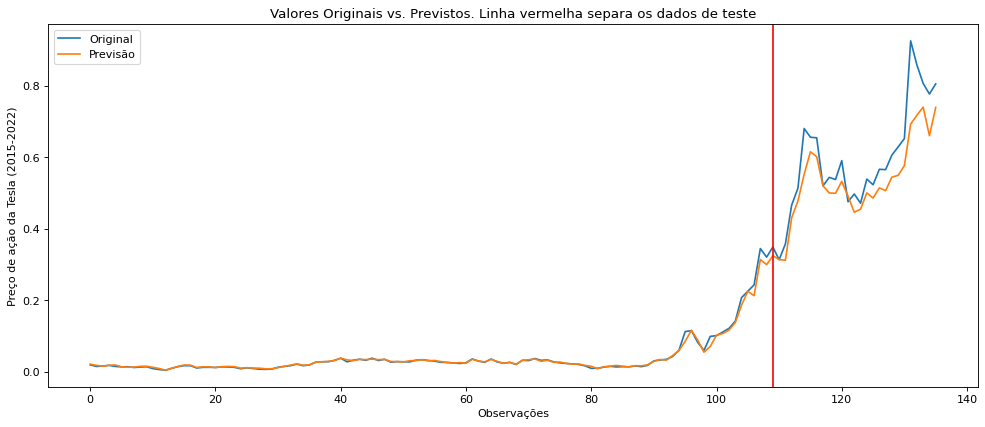

In [10]:
# Definindo função para imprimir o gráfico
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Original', 'Previsão'])
    plt.xlabel('Observações')
    plt.ylabel('Preço de ação da Tesla (2015-2022)')
    plt.title('Valores Originais vs. Previstos. Linha vermelha separa os dados de teste')

# Chamando a função para impressão do gráfico
plot_result(trainY, testY, train_predict, test_predict)

### Tarefa 2 - Adicionando mais uma camada LSTM no modelo anterior

Experimente adicionar mais uma camada LSTM após a primeira (mesmo número de unidades ocultas do item anterior). Reporte o resultado da mesma forma que o item anterior e comente se houve melhora.

Dica: para conectar duas camadas LSTM do Tensorflow, devemos usar o parâmetro return_sequences=True. A última camada LSTM antes da Dense não ser return_sequences=False.

In [11]:
# Definindo função para criação do modelo de RNN
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape,
                   activation=activation[0], return_sequences=True))
    model.add(LSTM(hidden_units, input_shape=input_shape,
                   activation=activation[0], return_sequences=False))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Chamando a função para criação do modelo
model = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=20, batch_size=1, verbose=2)

Epoch 1/20
109/109 - 6s - loss: 0.0011 - val_loss: 0.0796 - 6s/epoch - 55ms/step
Epoch 2/20
109/109 - 1s - loss: 7.0828e-04 - val_loss: 0.0096 - 973ms/epoch - 9ms/step
Epoch 3/20
109/109 - 1s - loss: 1.7482e-04 - val_loss: 0.0250 - 1s/epoch - 9ms/step
Epoch 4/20
109/109 - 1s - loss: 1.1243e-04 - val_loss: 0.0034 - 1s/epoch - 9ms/step
Epoch 5/20
109/109 - 1s - loss: 9.7581e-05 - val_loss: 0.0058 - 989ms/epoch - 9ms/step
Epoch 6/20
109/109 - 1s - loss: 1.4430e-04 - val_loss: 0.0201 - 1s/epoch - 13ms/step
Epoch 7/20
109/109 - 1s - loss: 1.8391e-04 - val_loss: 0.0060 - 1s/epoch - 14ms/step
Epoch 8/20
109/109 - 1s - loss: 7.1202e-05 - val_loss: 0.0032 - 1s/epoch - 14ms/step
Epoch 9/20
109/109 - 1s - loss: 2.5173e-04 - val_loss: 0.0178 - 996ms/epoch - 9ms/step
Epoch 10/20
109/109 - 1s - loss: 3.0904e-04 - val_loss: 0.0085 - 1s/epoch - 9ms/step
Epoch 11/20
109/109 - 1s - loss: 7.0786e-05 - val_loss: 0.0081 - 956ms/epoch - 9ms/step
Epoch 12/20
109/109 - 1s - loss: 4.1586e-05 - val_loss: 0.0037

In [12]:
# Realizando as predições
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Chamando a função para calcular e imprimir o erro médio quadrático
print_error(trainY, testY, train_predict, test_predict)

1/1 [==============================] - 0s 27ms/step
Raíz do Erro Médio Quadrático para Treino: 0.0056
Raíz do Erro Médio Quadrático para Teste: 0.0567


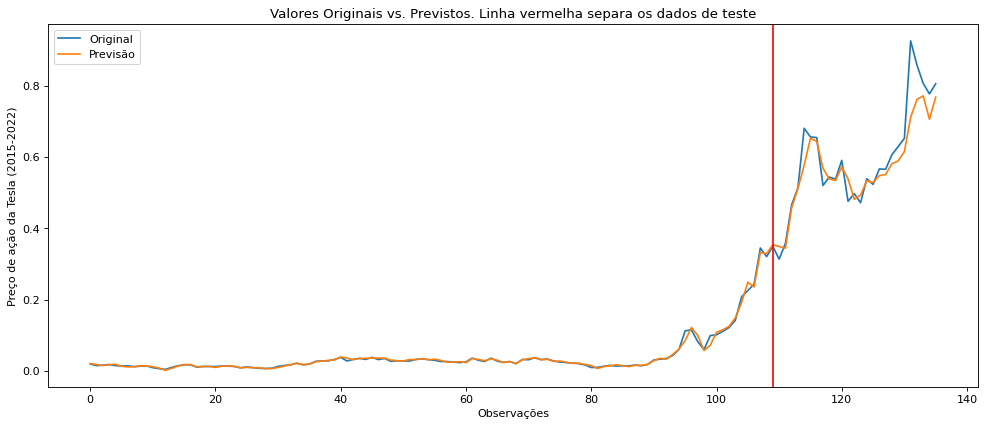

In [13]:
# Chamando a função para impressão do gráfico
plot_result(trainY, testY, train_predict, test_predict)

**Comentários desse exercício**: 

Conforme o resultado obtido, podemos perceber que a adição de mais uma camada LSTM na estrutura da rede representou uma pequena melhora na capacidade de previsão para os dados de teste. 

Raiz do erro médio quadrático para o modelo com uma camada LSTM: 0.0762

Raiz do erro médio quadrático para o modelo com duas camadas LSTM: 0.0567

### Tarefa 3 - Adicionando uma camada dropout após cada camada LSTM

Adicione um Dropout de 20% após cada camada LSTM e reporte se houve melhora.

In [37]:
# Definindo função para criação do modelo de RNN
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape,
                   activation=activation[0], return_sequences=True))
    model.add(Dropout(.2))
    model.add(LSTM(hidden_units, input_shape=input_shape,
                   activation=activation[0], return_sequences=False))
    model.add(Dropout(.2))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Chamando a função para criação do modelo
model = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=20, batch_size=1, verbose=2)

Epoch 1/20
109/109 - 6s - loss: 8.6025e-04 - val_loss: 0.0124 - 6s/epoch - 59ms/step
Epoch 2/20
109/109 - 1s - loss: 1.3741e-04 - val_loss: 0.0055 - 1s/epoch - 9ms/step
Epoch 3/20
109/109 - 1s - loss: 9.4255e-05 - val_loss: 0.0196 - 957ms/epoch - 9ms/step
Epoch 4/20
109/109 - 1s - loss: 1.4707e-04 - val_loss: 0.0033 - 1s/epoch - 10ms/step
Epoch 5/20
109/109 - 1s - loss: 5.1776e-04 - val_loss: 0.0800 - 976ms/epoch - 9ms/step
Epoch 6/20
109/109 - 1s - loss: 5.8887e-04 - val_loss: 0.0930 - 952ms/epoch - 9ms/step
Epoch 7/20
109/109 - 1s - loss: 7.0782e-04 - val_loss: 0.0737 - 1s/epoch - 13ms/step
Epoch 8/20
109/109 - 1s - loss: 2.6870e-04 - val_loss: 0.0099 - 1s/epoch - 13ms/step
Epoch 9/20
109/109 - 2s - loss: 1.2703e-04 - val_loss: 0.0050 - 2s/epoch - 14ms/step
Epoch 10/20
109/109 - 1s - loss: 1.1556e-04 - val_loss: 0.0055 - 961ms/epoch - 9ms/step
Epoch 11/20
109/109 - 1s - loss: 3.1211e-04 - val_loss: 0.0038 - 994ms/epoch - 9ms/step
Epoch 12/20
109/109 - 1s - loss: 1.6156e-04 - val_loss

In [38]:
# Realizando as predições
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Chamando a função para calcular e imprimir o erro médio quadrático
print_error(trainY, testY, train_predict, test_predict)

1/1 [==============================] - 0s 28ms/step
Raíz do Erro Médio Quadrático para Treino: 0.0069
Raíz do Erro Médio Quadrático para Teste: 0.0664


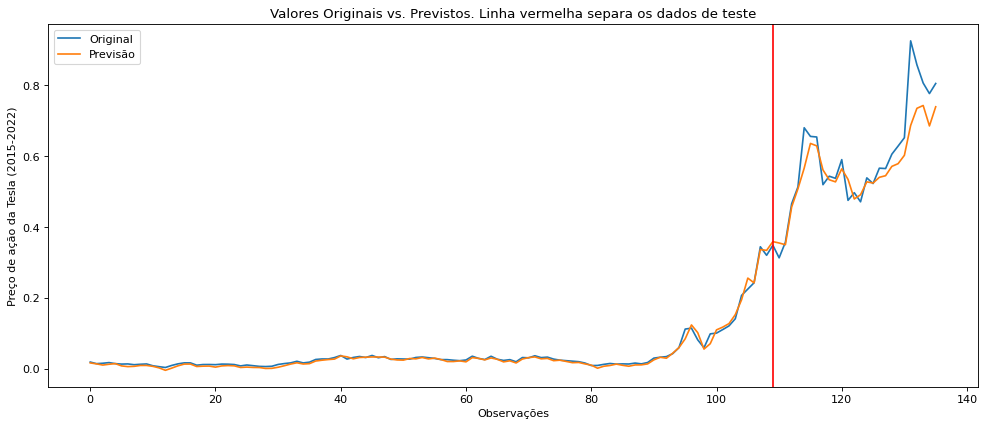

In [39]:
# Chamando a função para impressão do gráfico
plot_result(trainY, testY, train_predict, test_predict)

**Comentários desse exercício**: 

Conforme o resultado obtido, percebemos que a adição de dropout após as duas camadas LSTM não trouxe melhoras para o resultado da rede com os dados de teste. 

Raiz do erro médio quadrático para o modelo com uma camada LSTM: 0.0762

Raiz do erro médio quadrático para o modelo com duas camadas LSTM: 0.0567

Raiz do erro médio quadrático com adição de duas camadas dropout: 0.0664

### Tarefa 4 - Adicionando mais duas camadas LSTM + Dropout

Finalmente, modifique o modelo para que ele tenha 4 blocos LSTM (50 unidades ocultas) + Dropout (20 %) antes da camada Dense. Reporte os resultados deste último modelo e compare com os demais


In [40]:
# Definindo função para criação do modelo de RNN
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape,
                   activation=activation[0], return_sequences=True))
    model.add(Dropout(.2))
    model.add(LSTM(hidden_units, input_shape=input_shape,
                   activation=activation[0], return_sequences=True))
    model.add(Dropout(.2))
    model.add(LSTM(hidden_units, input_shape=input_shape,
                   activation=activation[0], return_sequences=True))
    model.add(Dropout(.2))
    model.add(LSTM(hidden_units, input_shape=input_shape,
                   activation=activation[0], return_sequences=False))
    model.add(Dropout(.2))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Chamando a função para criação do modelo
model = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=20, batch_size=1, verbose=2)

Epoch 1/20
109/109 - 13s - loss: 0.0019 - val_loss: 0.1160 - 13s/epoch - 117ms/step
Epoch 2/20
109/109 - 2s - loss: 0.0013 - val_loss: 0.0653 - 2s/epoch - 16ms/step
Epoch 3/20
109/109 - 2s - loss: 0.0012 - val_loss: 0.0097 - 2s/epoch - 16ms/step
Epoch 4/20
109/109 - 2s - loss: 3.4203e-04 - val_loss: 0.0165 - 2s/epoch - 20ms/step
Epoch 5/20
109/109 - 3s - loss: 1.6193e-04 - val_loss: 0.0103 - 3s/epoch - 25ms/step
Epoch 6/20
109/109 - 2s - loss: 3.4312e-04 - val_loss: 0.0304 - 2s/epoch - 17ms/step
Epoch 7/20
109/109 - 2s - loss: 5.7486e-04 - val_loss: 0.0067 - 2s/epoch - 16ms/step
Epoch 8/20
109/109 - 2s - loss: 0.0011 - val_loss: 0.0337 - 2s/epoch - 16ms/step
Epoch 9/20
109/109 - 2s - loss: 6.2758e-04 - val_loss: 0.0069 - 2s/epoch - 16ms/step
Epoch 10/20
109/109 - 2s - loss: 4.2884e-04 - val_loss: 0.0186 - 2s/epoch - 16ms/step
Epoch 11/20
109/109 - 2s - loss: 3.3780e-04 - val_loss: 0.0187 - 2s/epoch - 18ms/step
Epoch 12/20
109/109 - 3s - loss: 2.1026e-04 - val_loss: 0.0168 - 3s/epoch - 

In [41]:
# Realizando as predições
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Chamando a função para calcular e imprimir o erro médio quadrático
print_error(trainY, testY, train_predict, test_predict)

1/1 [==============================] - 0s 46ms/step
Raíz do Erro Médio Quadrático para Treino: 0.0160
Raíz do Erro Médio Quadrático para Teste: 0.1509


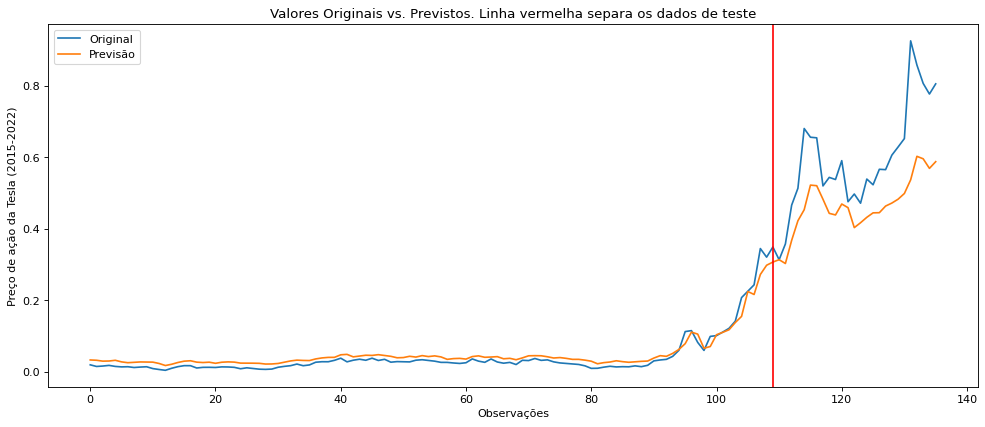

In [42]:
# Chamando a função para impressão do gráfico
plot_result(trainY, testY, train_predict, test_predict)

**Comentários desse exercício**: 

Conforme o resultado obtido, observamos que a adição de duas camadas LSTM com dropout representou uma piora significativa no resultado da rede para os dados de teste. O valor do erro saltou de 0.0664 na rede do exercício anterior para 0.1509 neste exercício. 

Raiz do erro médio quadrático para o modelo com uma camada LSTM: 0.0762

Raiz do erro médio quadrático para o modelo com duas camadas LSTM: 0.0567

Raiz do erro médio quadrático com adição de duas camadas dropout: 0.0664

Raiz do erro médio quadrático com 04 camadas LSTM + dropout: 0.1509